# Extract Modalities

In [1]:
from pathlib import Path

from video_content_search import extract_modalities, create_transcript
from video_content_search import utils

In [2]:
frame_interval = 70

input_videos_path = Path('~/Projects/video_companion/data/video/').expanduser()
extracted_data_path = Path('~/Projects/video_companion/data').expanduser()

video_id_to_path = utils.get_video_id_to_path(input_videos_path, extracted_data_path)

In [3]:
for video_id, video_output_path in video_id_to_path.items():
    if video_output_path.exists():
        print(f"{video_output_path} already exists, skipping")
        continue
    
    video_output_path.mkdir(parents=True)
    video_input_path = input_videos_path / f"{video_id}.mp4" 
    #  extract frames, audio and transcription
    extract_modalities.extract_images_from_video(
        video_input_path,
        video_output_path,
        video_id,
        frame_interval,
        display_frames=True
    )
    extract_modalities.extract_audio(video_input_path, video_output_path)
    create_transcript.transcribe_audio(str(Path(video_output_path / "audio.wav")), video_output_path)

/Users/akeldibek/Projects/video_companion/data/sounds already exists, skipping
/Users/akeldibek/Projects/video_companion/data/multimodal_ai already exists, skipping
/Users/akeldibek/Projects/video_companion/data/booking_youtube already exists, skipping
/Users/akeldibek/Projects/video_companion/data/clip_explained already exists, skipping


# Multimodal Vector Database

Choose your deployment. All options are listed here: https://weaviate.io/developers/weaviate

<div>
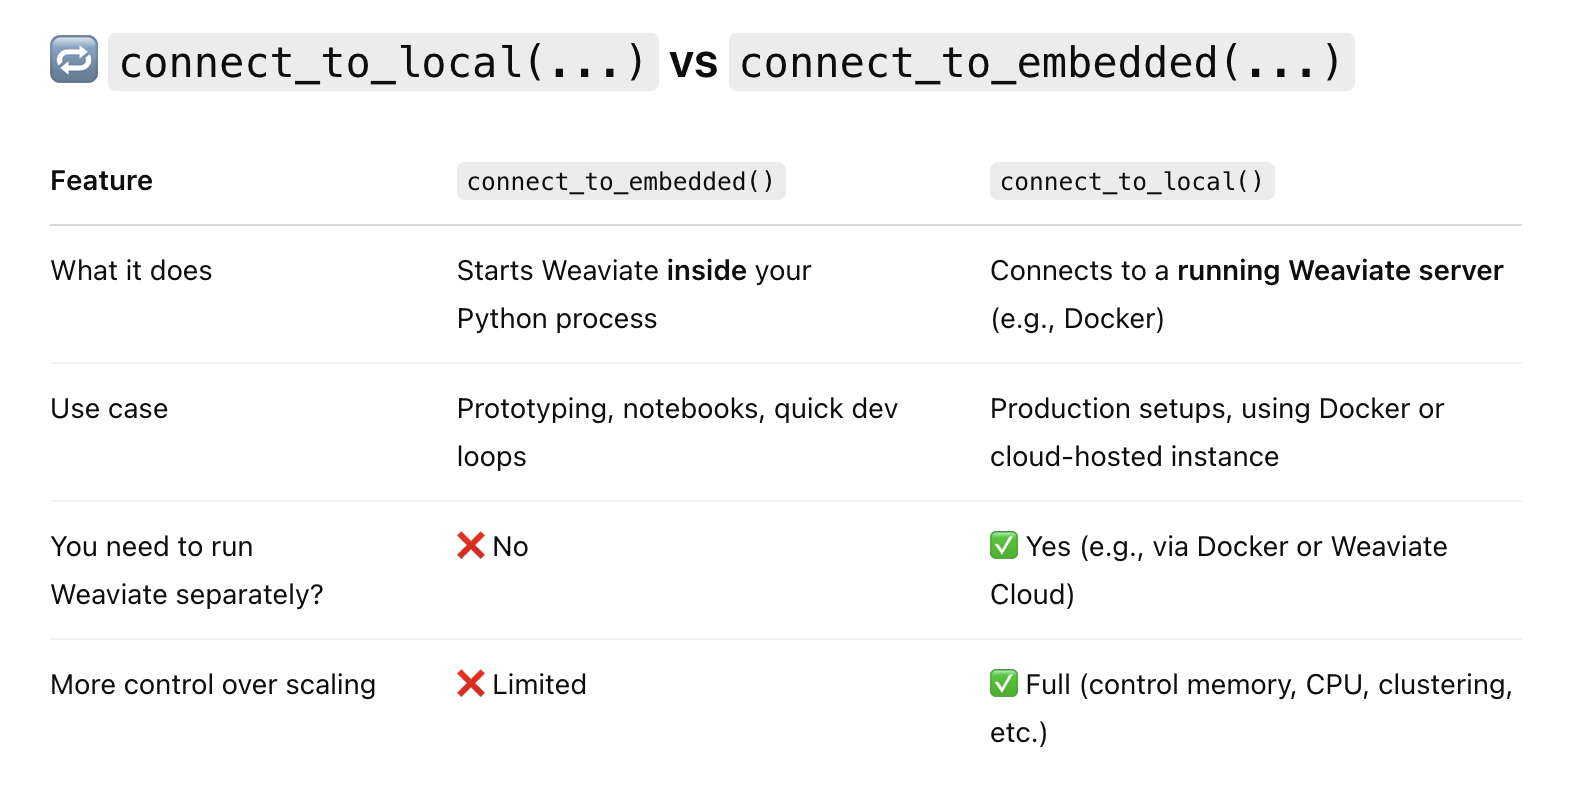
</div>

<div>
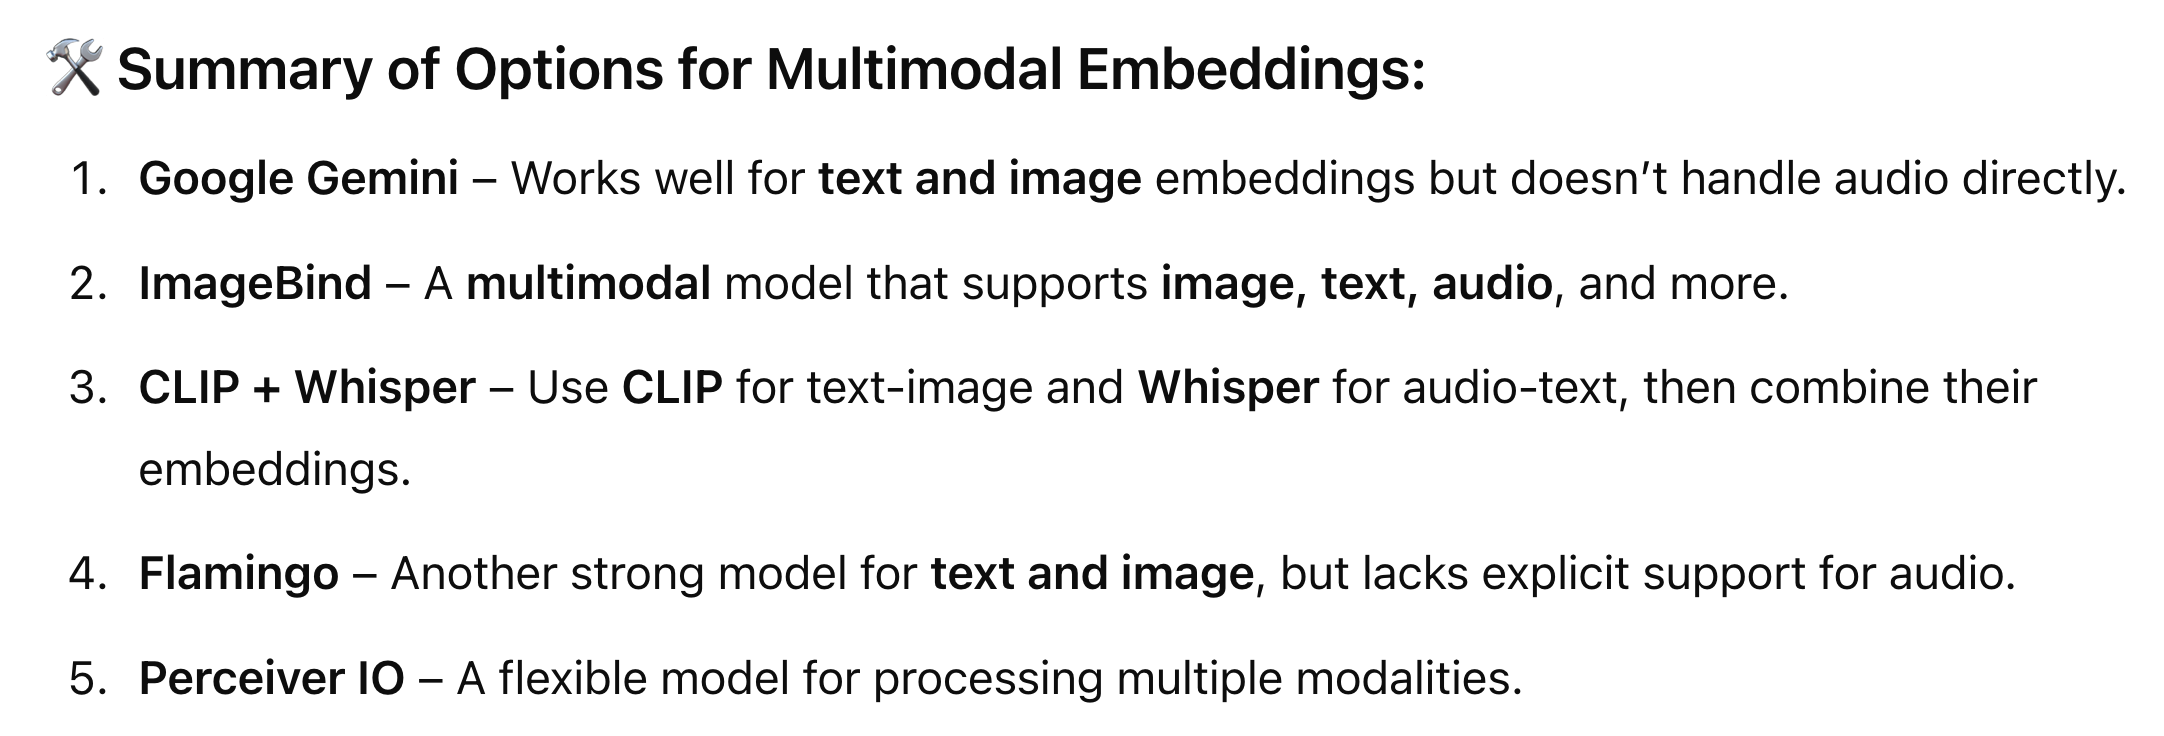
</div>

When you're using separate models for different modalities (such as Gemini for text and images, and another model like Whisper for audio), the embeddings generated by each model will likely come from separate vector spaces. This means you won't be able to directly compare or map an audio embedding to an image embedding, or even search across these modalities, unless you unify them into a shared space.

ImageBind is the best open source choice for image + speech + audio RAG.

In [9]:
from video_content_search.search import multimodal_vector_store
from video_content_search import preprocess


vs = multimodal_vector_store.WeviateMultimodal()
vs.connect_to_client()

collection_name = "youtube"
# vs.delete_collection(collection_name)
vs.create_collection(collection_name)
collection = vs.get_collection(collection_name)

2025-05-17 15:43:43,810 - INFO - HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
2025-05-17 15:43:43,851 - INFO - HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"
2025-05-17 15:43:43,907 - INFO - HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
2025-05-17 15:43:44,179 - INFO - HTTP Request: GET http://localhost:8080/v1/.well-known/ready "HTTP/1.1 200 OK"
2025-05-17 15:43:44,179 - INFO - is_read: True
2025-05-17 15:43:44,184 - INFO - HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"
2025-05-17 15:43:44,185 - INFO - metadata: {'hostname': 'http://[::]:8080', 'modules': {'multi2vec-bind': {'model': 'ImageBindModel', 'version': 1}}, 'version': '1.23.7'}
2025-05-17 15:43:44,188 - INFO - HTTP Request: GET http://localhost:8080/v1/schema/Youtube "HTTP/1.1 200 OK"
2025-05-17 15:43:44,189 - INFO - Collection youtube already exists
2025-05-17 15:43:44,191 - INFO - HTTP Request: GET

In [14]:
for video_id, video_output_path in video_id_to_path.items():
    print (f"adding data for video {video_id}")

    transcript_chunks = preprocess.chunk_transcript(Path(video_output_path / 'transcription.json'))
    
    print ("Adding text")
    vs.batch_insert_items(
        preprocess.format_text_chunks(transcript_chunks, video_id),
        collection,
        batch_size=10
    )
    # add audio
    print ("Adding audio data")
    vs.batch_insert_items(
        preprocess.collect_audio_chunks(video_output_path, video_id, chunk_duration_ms=5000),
        collection,
        batch_size=10
    )
    
    # add frames
    print ("Adding images")
    vs.batch_insert_items(
        preprocess.collect_frames(video_output_path, video_id),
        collection,
        batch_size=10
    )


adding data for video sounds
✅ Inserted batch 1 (10 items)
✅ Inserted batch 2 (3 items)
✅ Inserted batch 1 (10 items)
✅ Inserted batch 2 (10 items)
✅ Inserted batch 3 (2 items)


In [10]:
itr = collection.iterator(
    include_vector=True, # in case you want to see the vectors
)

for item in itr:
    print(item.uuid, item.properties)

00797058-e973-4768-b3cb-7e2fa4973ad2 {'mediaType': 'image', 'path': 'clip_explained_27860.jpg', 'video_id': 'clip_explained', 'timestamp': 1161994}
00854ff7-0a20-408c-babb-c183cefeb432 {'mediaType': 'image', 'path': 'multimodal_ai_3450.jpg', 'video_id': 'multimodal_ai', 'timestamp': 143893}
00b7917c-8c7f-4268-a2ef-1078eb2c8ba6 {'mediaType': 'image', 'path': 'booking_youtube_7490.jpg', 'video_id': 'booking_youtube', 'timestamp': 249916}
00d1b5c3-fab3-48bf-9006-e69cb9335fac {'mediaType': 'image', 'path': 'multimodal_ai_850.jpg', 'video_id': 'multimodal_ai', 'timestamp': 35452}
011050d5-96ce-46a4-9eba-b114728afb4e {'mediaType': 'image', 'path': 'clip_explained_26600.jpg', 'video_id': 'clip_explained', 'timestamp': 1109441}
015d9fba-0754-47cd-9939-e9f6cf4a91c1 {'mediaType': 'image', 'path': 'clip_explained_6300.jpg', 'video_id': 'clip_explained', 'timestamp': 262762}
015e8cee-50e0-4371-9f6a-05fa9dc25a31 {'mediaType': 'image', 'path': 'clip_explained_21140.jpg', 'video_id': 'clip_explained'

# Querying

In [3]:
import base64
from IPython.display import Image, Audio, display
import io


def display_image(img_data_b64):
    img_data = base64.b64decode(img_data_b64)
    display(Image(data=img_data))

def play_audio(audio_data_b64):
    audio_data = base64.b64decode(audio_data_b64)
    
    display(Audio(data=audio_data))

In [4]:
import video_content_search.search.multimodal_vector_store as mvs
from video_content_search import preprocess


vs = mvs.WeviateMultimodal()
vs.connect_to_client()

collection_name = "youtube"
collection = vs.get_collection(collection_name)

2025-05-17 21:14:02,227 - INFO - HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
2025-05-17 21:14:02,248 - INFO - HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"
2025-05-17 21:14:02,323 - INFO - HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
2025-05-17 21:14:02,346 - INFO - HTTP Request: GET http://localhost:8080/v1/.well-known/ready "HTTP/1.1 200 OK"
2025-05-17 21:14:02,346 - INFO - is_read: True
2025-05-17 21:14:02,349 - INFO - HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"
2025-05-17 21:14:02,350 - INFO - metadata: {'hostname': 'http://[::]:8080', 'modules': {'multi2vec-bind': {'model': 'ImageBindModel', 'version': 1}}, 'version': '1.23.7'}
2025-05-17 21:14:02,352 - INFO - HTTP Request: GET http://localhost:8080/v1/schema/Youtube "HTTP/1.1 200 OK"
2025-05-17 21:14:02,352 - INFO - Collection youtube already exists
2025-05-17 21:14:02,355 - INFO - HTTP Request: GET

In [8]:
response = vs.query_multimodal(
    collection,
    query="baby",
    input_modality=mvs.Modality.TEXT,
    output_modality=mvs.Modality.AUDIO
)

In [10]:
img_base64 = preprocess.file_to_base64(f"{extracted_data_path}/query_samples/laugh.png")

response = vs.query_multimodal(
    collection,
    query=img_base64,
    input_modality=mvs.Modality.IMAGE,
    output_modality=mvs.Modality.AUDIO
)

In [17]:
audio_base64 = preprocess.file_to_base64(f"{extracted_data_path}/query_samples/lion_growl.wav")

response = vs.query_multimodal(
    collection,
    query=audio_base64,
    input_modality=mvs.Modality.AUDIO,
    output_modality=mvs.Modality.IMAGE
)

In [9]:
for i in range(len(response.objects)):
    print (f"/********RESPONSE {i} *********")
    
    props = response.objects[i].properties
    meta = response.objects[i].metadata

    if props['mediaType'] == 'text':
        print (props['text'])
    if props['mediaType'] == 'image':
        display_image(props["image"])
    if props['mediaType'] == 'audio':
        play_audio(props['audio'])
        
    print (f"Similarity distance is {meta.distance}")

/********RESPONSE 0 *********


Similarity distance is 0.8491345643997192
/********RESPONSE 1 *********


Similarity distance is 0.8554962277412415
/********RESPONSE 2 *********


Similarity distance is 0.8606962561607361
/********RESPONSE 3 *********


Similarity distance is 0.8610466718673706
/********RESPONSE 4 *********


Similarity distance is 0.8651414513587952
/********RESPONSE 5 *********


Similarity distance is 0.8672031164169312
/********RESPONSE 6 *********


Similarity distance is 0.8673558235168457
/********RESPONSE 7 *********


Similarity distance is 0.868506133556366
/********RESPONSE 8 *********


Similarity distance is 0.8686306476593018
/********RESPONSE 9 *********


Similarity distance is 0.868803858757019
